**Packages**

In [2]:
import re
import numpy as np

import spacy

In [3]:
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

In [4]:
import pyLDAvis
import pyLDAvis.gensim 
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
import imp

tools = imp.load_source('tools', '../lda_tools.py')

**The data set**

In [6]:
import pandas as pd

In [7]:
df = pd.read_csv('../data/price_of_anarchy_articles_meta_data.csv', index_col=0)

In [8]:
extra = pd.read_csv('../data/new_price_data.csv', index_col=0)

In [9]:
df = pd.concat([df, extra])

//anaconda3/envs/literature/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [10]:
data = df[['abstract', 'unique_key', 'title', 'date']]

In [11]:
data = data.drop_duplicates()

In [12]:
data = data.reset_index(drop=True)

In [13]:
data.head()

,abstract,unique_key,title,date
0,The success of the Internet is remarkable in l...,1e6ace55d7fedd0e4eeed19012c6755b,A network pricing game for selfish traffic,2007.0
1,Contrary to early expectations recent studies...,3546dd01c0a6376828bbafaaa37b87c7,The Price of Adherence: Qualitative Findings F...,2006.0
2,According to the proportional allocation mecha...,1d8ae082a051688dbd93e495f0ef4f8e,Welfare Guarantees for Proportional Allocations,2016.0
3,We study profit sharing games in which players...,84428d0eedf0a0623e846ca61245a388,Profit Sharing with Thresholds and Non-monoton...,2016.0
4,We continue the study of the performance of mi...,b5501f437688ea148cdea4c2c372bc56,On the performance of mildly greedy players in...,2016.0


In [14]:
data.describe()

,date
count,792.000000
mean,2012.166667
std,3.928566
min,1999.000000
25%,2009.000000
50%,2013.000000
75%,2015.000000
max,2018.000000


**Sentences to words**

In [15]:
words = list(tools.sentences_to_words(data['abstract'].values))

**Cleaning data set**

In [16]:
from nltk.corpus import stopwords

In [17]:
stop_words = stopwords.words('english')

In [18]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(words, min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [19]:
lemmatized_words = tools.clean_words(words, bigram, stop_words)

In [20]:
len(lemmatized_words)

798

In [21]:
len(words)

798

**Create corpus**

In [22]:
id2word = corpora.Dictionary(lemmatized_words)

texts = lemmatized_words

corpus = [id2word.doc2bow(text) for text in texts]

**Create model and select number of topics**

In [23]:
mallet_path = '/Users/storm/rsc/mallet-2.0.8/bin/mallet'

In [24]:
limit = 8

In [25]:
model_list, coherence_values = tools.compute_coherence_values(limit=limit,
                                                              step=1,
                                                              mallet_path=mallet_path,
                                                              dictionary=id2word,
                                                              corpus=corpus,
                                                              texts=lemmatized_words)

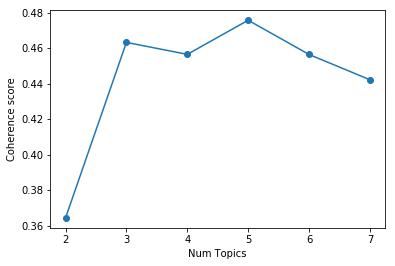

In [26]:
fig = plt.subplots()

num_of_topics = range(2, limit, 1)
plt.plot(num_of_topics, coherence_values, '-o')

plt.xlabel("Num Topics")
plt.ylabel("Coherence score");

In [27]:
for num, cv in zip(num_of_topics, coherence_values):
    print("Num Topics =", num, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3643
Num Topics = 3  has Coherence Value of 0.4632
Num Topics = 4  has Coherence Value of 0.4564
Num Topics = 5  has Coherence Value of 0.4757
Num Topics = 6  has Coherence Value of 0.4564
Num Topics = 7  has Coherence Value of 0.4421


In [28]:
max_coherence_value = max(coherence_values)
max_index = coherence_values.index(max_coherence_value)

In [29]:
num_of_topics[max_index]

5

**Model for num topics = 5**

In [30]:
optimal_model = model_list[max_index]
model_topics = optimal_model.show_topics(formatted=False)

**Assign Documents to Topic**

In [31]:
def format_topics_sentences(ldamodel,
                            corpus,
                            data_frame):
    data_with_topics = pd.DataFrame()

    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0: 
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                data_with_topics = data_with_topics.append(pd.Series([int(topic_num),
                                                                  round(prop_topic,4),
                                                                  topic_keywords]),
                                                         ignore_index=True)
            else:
                break
    data_with_topics.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    data_with_topics = pd.concat([data_with_topics, data_frame], axis=1)
    return data_with_topics

In [32]:
data_with_topics = format_topics_sentences(ldamodel=optimal_model,
                                           corpus=corpus,
                                           data_frame=data)

In [33]:
data_with_topics.head()

,Dominant_Topic,Perc_Contribution,Topic_Keywords,abstract,unique_key,title,date
0,2.0,0.2410,"user, problem, network, mechanism, paper, prop...",The success of the Internet is remarkable in l...,1e6ace55d7fedd0e4eeed19012c6755b,A network pricing game for selfish traffic,2007.0
1,0.0,0.3012,"theory, state, policy, power, article, interna...",Contrary to early expectations recent studies...,3546dd01c0a6376828bbafaaa37b87c7,The Price of Adherence: Qualitative Findings F...,2006.0
2,2.0,0.2654,"user, problem, network, mechanism, paper, prop...",According to the proportional allocation mecha...,1d8ae082a051688dbd93e495f0ef4f8e,Welfare Guarantees for Proportional Allocations,2016.0
3,1.0,0.5298,"game, price, anarchy, player, cost, show, equi...",We study profit sharing games in which players...,84428d0eedf0a0623e846ca61245a388,Profit Sharing with Thresholds and Non-monoton...,2016.0
4,1.0,0.2370,"game, price, anarchy, player, cost, show, equi...",We continue the study of the performance of mi...,b5501f437688ea148cdea4c2c372bc56,On the performance of mildly greedy players in...,2016.0


**Find the most representative document for each topic**

In [34]:
documents_of_topic = pd.DataFrame()

documents_of_topic_grpd = data_with_topics.groupby('Dominant_Topic')

for i, grp in documents_of_topic_grpd:
    documents_of_topic = pd.concat([documents_of_topic, 
                                    grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                    axis=0)
documents_of_topic.reset_index(drop=True, inplace=True)
documents_of_topic = documents_of_topic[['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords','title', 'date']]

In [35]:
documents_of_topic.values

array([[0.0, 0.6505,
        'theory, state, policy, power, article, international, political, social, global, economic',
        "Imperialism or globalisation? … Or imperialism and globalisation: Theorising the international after Rosenberg's ‘post-mortem’",
        2013.0],
       [1.0, 0.634,
        'game, price, anarchy, player, cost, show, equilibrium, set, congestion, utility',
        'Bicretieria Optimization in Routing Games', 2008.0],
       [2.0, 0.6783,
        'user, problem, network, mechanism, paper, propose, design, performance, system, equilibrium',
        'On Uplink Virtual MIMO with Device Relaying Cooperation Enforcement in 5G Networks',
        2018.0],
       [3.0, 0.5849,
        'model, demand, system, market, present, increase, individual, condition, determine, paper',
        'Production capacity buildup and double marginalization mitigation in a dynamic supply chain',
        2014.0],
       [4.0, 0.5828,
        'network, price, agent, show, study, time, a

**Stats summary for each topic**

In [36]:
topic_counts = data_with_topics['Dominant_Topic'].value_counts()

topic_contribution = round(topic_counts/topic_counts.sum(), 4)

In [37]:
stats= pd.DataFrame([topic_counts.index,
                     topic_counts,
                     topic_contribution]).T
stats.columns = ['Dominant_Topic', 'Num of Documents', 'Percentage of Documents']

In [38]:
stats

,Dominant_Topic,Num of Documents,Percentage of Documents
0,0.0,202.0,0.2531
1,1.0,187.0,0.2343
2,2.0,158.0,0.1980
3,4.0,151.0,0.1892
4,3.0,100.0,0.1253


In [39]:
topic_num_keywords = data_with_topics[['Dominant_Topic', 'Topic_Keywords']].drop_duplicates()

df_topics = pd.merge(stats, topic_num_keywords, on='Dominant_Topic')

In [40]:
df_topics['Topic_Keywords'].values

array(['theory, state, policy, power, article, international, political, social, global, economic',
       'game, price, anarchy, player, cost, show, equilibrium, set, congestion, utility',
       'user, problem, network, mechanism, paper, propose, design, performance, system, equilibrium',
       'network, price, agent, show, study, time, anarchy, model, case, traffic',
       'model, demand, system, market, present, increase, individual, condition, determine, paper'],
      dtype=object)

In [41]:
topic_num_keywords

,Dominant_Topic,Topic_Keywords
0,2.0,"user, problem, network, mechanism, paper, prop..."
1,0.0,"theory, state, policy, power, article, interna..."
3,1.0,"game, price, anarchy, player, cost, show, equi..."
7,4.0,"network, price, agent, show, study, time, anar..."
15,3.0,"model, demand, system, market, present, increa..."


**Number of topics per year**

In [42]:
yearly = (
        data_with_topics.groupby(["Dominant_Topic", "date"]).size().reset_index().groupby("date").size()
    )

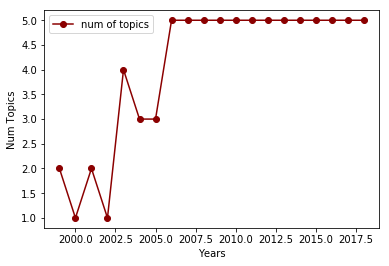

In [43]:
fig = plt.subplots()
plt.plot(yearly, '-o', color='darkred', label='num of topics');

plt.legend();
plt.ylabel("Num Topics")
plt.xlabel("Years");

**Number of articles per topic per year**

In [44]:
groups = ['A', 'B', 'C', 'D', 'E', 'F']

In [45]:
selected_num_topics = num_of_topics[max_index]

In [46]:
table = data_with_topics.groupby(['date', 'Dominant_Topic']).size()

In [47]:
table

date    Dominant_Topic
1999.0  1.0                1
        3.0                1
2000.0  0.0                1
2001.0  0.0                1
        3.0                1
                          ..
2018.0  0.0                3
        1.0               15
        2.0               17
        3.0               11
        4.0               12
Length: 81, dtype: int64

In [48]:
years = sorted(data_with_topics.date.unique())

In [49]:
counts = []
for year in years:
    specific_year = data_with_topics[data_with_topics['date'] == year]
    count = []
    for topic in range(selected_num_topics):
        count.append(specific_year[specific_year["Dominant_Topic"] == topic].count().values[0])
    counts.append(count)

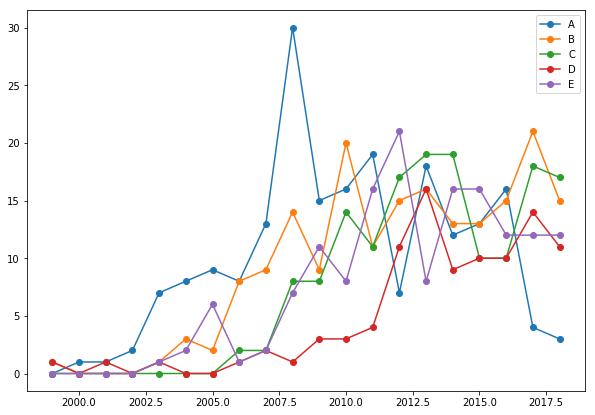

In [50]:
fig = plt.subplots(figsize=(10, 7))
for i in range(selected_num_topics):
    plt.plot(years, [c[i] for c in counts], '-o', label=f"{groups[i]}");
plt.legend();

No handles with labels found to put in legend.


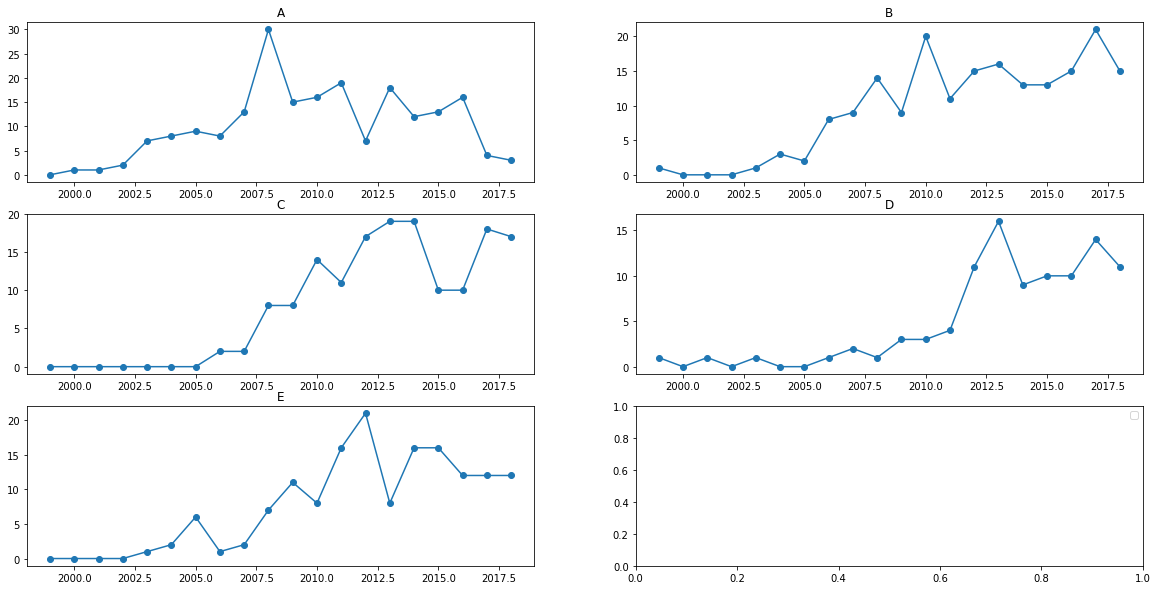

In [51]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 10))
for i in range(selected_num_topics):
    index = (int(i / 2), i % 2)
    axes[index].plot(years, [c[i] for c in counts], '-o',);
    axes[index].set_title(groups[i])
plt.legend();

In [52]:
subset_of_years = years[5:]

In [53]:
counts = []
for year in subset_of_years:
    specific_year = data_with_topics[data_with_topics['date'] == year]
    count = []
    for topic in range(selected_num_topics):
        count.append(specific_year[specific_year["Dominant_Topic"] == topic].count().values[0])
    counts.append(count)

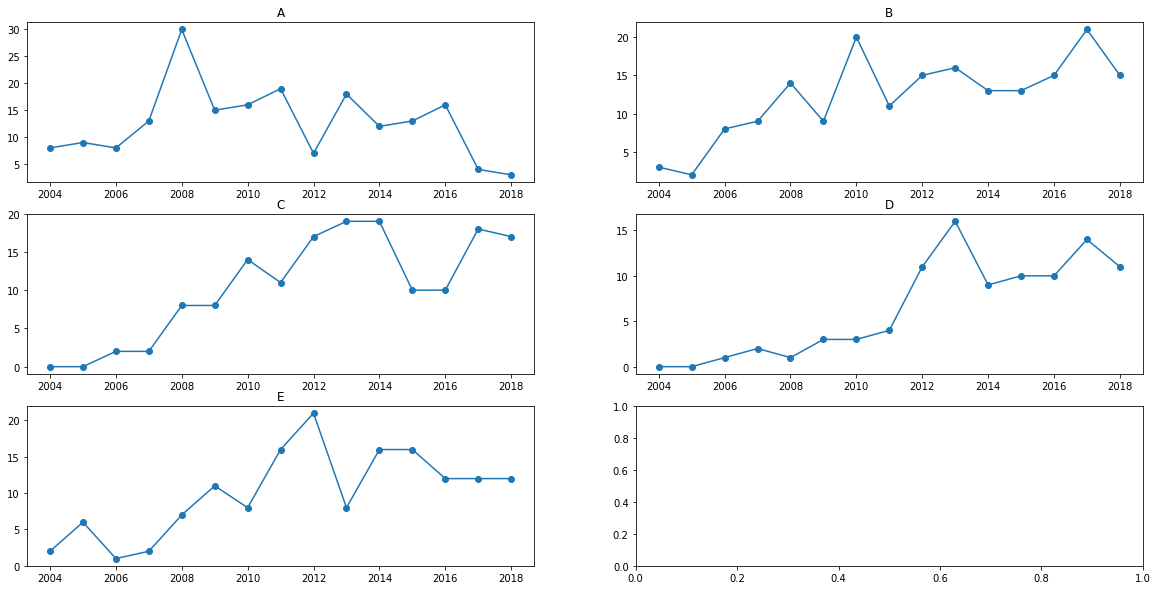

In [54]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 10))
for i in range(selected_num_topics):
    index = (int(i / 2), i % 2)
    axes[index].plot(subset_of_years, [c[i] for c in counts], '-o');
    axes[index].set_title(groups[i])

In [55]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_of_topics[max_index], 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [63]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

//anaconda3/envs/literature/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.235719 -0.079884       1        1  52.755947
2     -0.197162 -0.165757       2        1  19.193096
4     -0.063353 -0.048170       3        1  13.463031
0      0.141721  0.067471       4        1   9.285010
3     -0.116925  0.226340       5        1   5.302908, topic_info=    Category         Freq     Term        Total  loglift  logprob
41   Default  1032.000000    price  1032.000000  30.0000  30.0000
17   Default   931.000000     game   931.000000  29.0000  29.0000
33   Default   834.000000  network   834.000000  28.0000  28.0000
253  Default   617.000000  anarchy   617.000000  27.0000  27.0000
71   Default   448.000000     cost   448.000000  26.0000  26.0000
..       ...          ...      ...          ...      ...      ...
240   Topic5    11.239897  outcome    40.586197   1.6530  -5.6171
714   Topic5    11.146144     call    61.827190   1.2237  -5.6255
31    Topic5    12.344012    model   358.723785  -0.4325  -5.5234
250   Topic5    11.852894      use   329.074188  -0.3868  -5.5640
707   Topic5    10.968465     pure   109.034340   0.6403  -5.6415

[308 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
0         1  0.294921      access
0         3  0.678317      access
0         5  0.014746      access
414       1  0.251358      action
414       2  0.228508      action
...     ...       ...         ...
64        5  0.081844        work
1158      1  0.096604       world
1158      2  0.740633       world
1158      3  0.161007       world
281       1  0.979900  worst_case

[473 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 5, 1, 4])